## **Introduction to Image Processing**

Mojdeh Rastgoo - Desire Sidibe

## 3. Interpolation and Blending

 Importing necessary libraries/modules and functions

In [1]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from PIL import Image

import cv2


Pretty printing has been turned OFF


### 3.1  Resizing an image size using different interpolation functions

** Q.1 Resize the `lena` or `vibot` image using nearest, bilinear and bicubic function.** 

You can define your function which accept the model and resize size from the user or just run a script.

In [2]:
#Define a function that accepts an image, a size to resize to (such as 20%
#or 0.2) to determine the size to resize to, and include the type of
#resize in quotations, whether bilinear, nearest, or bicubic.
def img_resize (image, resize_size, type_of_resize):
    image = misc.imresize(image, resize_size, interp = type_of_resize)
    return image;

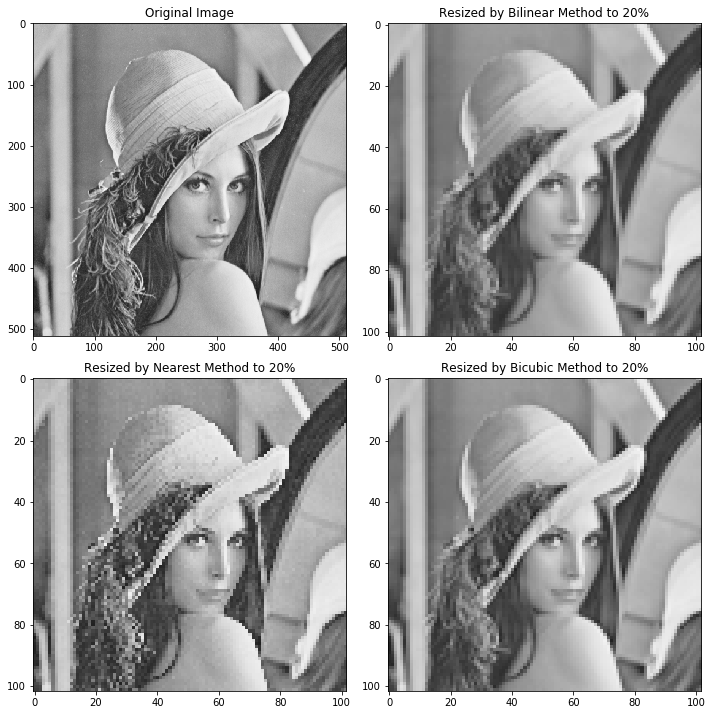

In [3]:
#Import the lena image to resize
img_path = './images/'
img_name = 'lena-grey.bmp'
lena_im = io.imread(img_path.__add__(img_name))

#Perform image required image resizing on the lena image
resized_lena_bilinear = img_resize(lena_im, 20, 'bilinear')
resized_lena_nearest = img_resize(lena_im, 20, 'nearest')
resized_lena_bicubic = img_resize(lena_im, 20, 'bicubic')

#Plot the images together to compare
fig = plt.figure(figsize=(10, 10))

plt.subplot(221)
io.imshow(lena_im, cmap = cm.Greys_r)
plt.title("Original Image")

plt.subplot(222)
io.imshow(resized_lena_bilinear, cmap = cm.Greys_r)
plt.title("Resized by Bilinear Method to 20%")

plt.subplot(223)
io.imshow(resized_lena_nearest, cmap = cm.Greys_r)
plt.title("Resized by Nearest Method to 20%")

plt.subplot(224)
io.imshow(resized_lena_bicubic, cmap = cm.Greys_r)
plt.title("Resized by Bicubic Method to 20%");

**Q.2 Write three functions that performs `simple_blend`, `alpha_blend` and `pyramid_blend`**

** Using your functions, blend `orange` and `apple` images together.**


In [53]:
def simple_blend (image1, image2):
    #Define a test to ensure images can be blended
    if (np.shape(image1) != np.shape(image2)):
        print("Image mismatch: images are different sizes")
        
    #Define the blended image shape and fill with zeroes
    #Define x, the splitting point of the blended image
    blended_image = np.zeros_like(image1)
    im1_height, im1_width = np.shape(image1)
    im2_height, im2_width = np.shape(image2)
    x = int(im1_width/2)
    
    #Fill the blended image with half image1 and half image2
    blended_image[:, :x] = image1[:, :x]
    blended_image[:, x:] = image2[:, x:]
    
    return(blended_image)

def alpha_blend (image1, image2, window):
    #Define a test to ensure images can be blended
    if (np.shape(image1) != np.shape(image2)):
        print("Image mismatch: images are different sizes")
    im1_height, im1_width = np.shape(image1)
    im2_height, im2_width = np.shape(image2)
    blended_image = np.zeros(image1.shape)
    
    #Define the window size and a vector that spans its width and define an alpha function
    #that spans the width, allowing blending
    x1 = int(im1_width/2)-int(window/2)
    x2 = int(im1_width/2)+int(window/2)
    x = np.arange(x1,x2)
    alpha = x/(x1-x2) - x2/(x1-x2)
    
    #Fill the blended image outside the defined window with half image1 and half image2
    #and inside the window, use the alpha function to fill
    blended_image[:, :x1] = image1[:, :x1]
    blended_image[:, x2:] = image2[:, x2:]
    blended_image[:,x] = alpha*image1[:,x] + (1-alpha)*image2[:,x]
   
    return(blended_image)

def pyramid_blend (image1, image2):
    #Define a test to ensure images can be blended
    if (np.shape(image1) != np.shape(image2)):
        print("Image mismatch: images are different sizes")
        
    im1_height, im1_width = np.shape(image1)
    im2_height, im2_width = np.shape(image2)
    
    #Create a gaussian pyramid of 5 levels for image1 and image2,
    #saving the images into an array gp1 and gp2
    gaussian1 = image1.copy()
    gp1 = [gaussian1]
    for i in range(1,5):
        gaussian1 = cv2.pyrDown(gaussian1)
        gp1.append(gaussian1)
    gaussian2 = image2.copy()
    gp2 = [gaussian2]
    for i in range(1,5):
        gaussian2 = cv2.pyrDown(gaussian2)
        gp2.append(gaussian2)
        
    #Create a laplacian pyramid for image1 and image2 using comparisons
    #between that levels in the gaussian pyramid and the expanded version of
    #its upper level in the Gaussian pyramid
    laplacian1 = [gp1[4]]
    for i in range(4,0,-1):
        GE = cv2.pyrUp(gp1[i])
        if i == 3:
            GE = np.delete(GE,75,axis=0)
            GE = np.delete(GE,75,axis=1)
        L = gp1[i-1] - GE
        laplacian1.append(L)
        
    laplacian2 = [gp2[4]]
    for i in range(4,0,-1):
        GE = cv2.pyrUp(gp2[i])
        if i == 3:
            GE = np.delete(GE,75,axis=0)
            GE = np.delete(GE,75,axis=1)
        L = gp2[i-1] - GE
        laplacian1.append(L)
    
    #Combine the right and left halves of the images in each level
    LS = []
    for level1,level2 in zip(laplacian1,laplacian2):
        height, width = level1.shape
        blended_image = np.hstack((level1[:,:int(width/2)],level2[:,int(width/2):]))
        LS.append(blended_image)
    
    #Form a combinded pyramid from the two laplacian pyramids using 
    #nodes of the gaussian pyramid as weights
    blended_image = LS[0]
    for i in range(1,5):
        print(np.shape(blended_image))
        blended_image = cv2.pyrUp(blended_image)
        blended_image = cv2.add(blended_image, LS[i])
    

    
    return(blended_image)

In [54]:
img_name = 'orange.jpeg'
orange = io.imread(img_path.__add__(img_name),as_grey = True)
img_name = 'apple.jpeg'
apple = io.imread(img_path.__add__(img_name),as_grey = True)


#simple_orpple = simple_blend(orange,apple)
#alpha_orpple = alpha_blend(orange, apple, 100)
pyramid_orpple = pyramid_blend(orange,apple)


#Plot the images together to compare
fig = plt.figure(figsize=(10, 10))

plt.subplot(131)
io.imshow(simple_orpple)
plt.title("Simple Blended Image")

plt.subplot(132)
io.imshow(alpha_orpple)
plt.title("Alpha Blended Image")

#plt.subplot(133)
#io.imshow(resized_lena_nearest, cmap = cm.Greys_r)
#plt.title("Pyramid Blended Image");


(19, 19)


IndexError: list index out of range